## Optogenetic Two Component System Control Model
This file demonstrates the closed loop simulation (P-control regulation) of the optogenetic two component system using minimal model

In [1]:
# Import all the needed modules here 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lmfit


# run_constant_3eqn is the simulator that runs the open loop experiment using the minimal model
from model_equations_and_simulators.run_constant_3eqn import run_constant
# run_p_control_3eqn is the simulator that runs the closed loop experiment (P-control) using the minimal model
from model_equations_and_simulators.run_p_control_3eqn import run_p_control


In [2]:
# %%
# Load experimental fluorescence datasets
data1 = pd.read_csv('experiment_data/P-FL_OD_run_data_042325.csv')
data2 = pd.read_csv('experiment_data/P-FL_OD_run_data_040625.csv')

# Extract experimental replicates
P1_data1 = data1[['SP1_1', 'SP1_2', 'SP1_3', 'SP1_4', 'SP1_5', 'SP1_6']].to_numpy()
P2_data1 = data1[['SP2_1', 'SP2_2', 'SP2_3', 'SP2_4', 'SP2_5', 'SP2_6']].to_numpy()

P1_data2 = data2[['SP1_1', 'SP1_2', 'SP1_3']].to_numpy()
P2_data2 = data2[['SP2_1', 'SP2_2', 'SP2_3']].to_numpy()

green_data1 = data1[['G1']].to_numpy()
green_data2 = data2[['G1', 'G2', 'G3']].to_numpy()
red_data1 = data1[['R1']].to_numpy()
red_data2 = data2[['R1', 'R2', 'R3']].to_numpy()

# Truncate all data to shared minimum length
min_len = min(P1_data1.shape[0], P1_data2.shape[0])
P1_data1 = P1_data1[:min_len]; P2_data1 = P2_data1[:min_len]
P1_data2 = P1_data2[:min_len]; P2_data2 = P2_data2[:min_len]
green_data1 = green_data1[:min_len]; green_data2 = green_data2[:min_len]
red_data1 = red_data1[:min_len]; red_data2 = red_data2[:min_len]


In [3]:
# %%
# Merge all experimental replicates
P1_all = np.hstack((P1_data1, P1_data2))
P2_all = np.hstack((P2_data1, P2_data2))
green_all = np.hstack((green_data1, green_data2))
red_all = np.hstack((red_data1, red_data2))

# Compute means and standard deviations
P1_mean = np.mean(P1_all, axis=1)
P1_std = np.std(P1_all, axis=1)
P2_mean = np.mean(P2_all, axis=1)
P2_std = np.std(P2_all, axis=1)
green_mean = np.mean(green_all, axis=1)
green_std = np.std(green_all, axis=1)
red_mean = np.mean(red_all, axis=1)
red_std = np.std(red_all, axis=1)


In [4]:
# Define simulation parameters
# Time parameters
interval = 10
time = np.arange(interval, (min_len + 1) * interval, interval)
t_final = 16 * 60

# Setpoints from experiments
st_pt_1 = 11500
st_pt_2 = 18500

# Normalize scale using green max
green_max = np.max(green_mean)

# Define color dictionary
color_dict = {
    'set_point_1': '#A06AAF', 
    'set_point_2': '#F29935',
    'green': '#74B867',
    'red': '#D94633'
}


In [5]:
# Parameter setup
p = pd.read_csv('parameters/3_eqn_model_params_file.csv').to_numpy()
p = p[:,2]

params = lmfit.Parameters()

params.add('k_tx', value=p[0], min=0.1, max=20)
params.add('d_m', value=p[1], min=0.05, max=0.5)
params.add('k_tl', value=p[2], min=0.1, max=5)
params.add('Kc', value=p[3], min=0.001, max=1000)
params.add('l0', value=p[4], min=0.001, max=0.5)
params.add('n_gamma', value=p[5], min=0.2, max=0.9)
params.add('d_p', value=p[6], min=1e-6, max=0.001)
params.add('k_gr', value=p[7], min=0.001, max=1.0, vary = False)
params.add('Ac_green', value=p[8], min=1, max=100)
params.add('Ac_dark', value=p[9], min=1, max=100)
params.add('Ac_red', value=p[10], min=1e-3, max=100)
params.add('C_max', value=p[11], vary=False)
params.add('C_0', value=p[12], vary=False)
params.add('M_0', value=p[13], min = 0, max = 1e3)
params.add('P_0', value=p[14], min = 0, max = 1e3)

# Initial conditions: [M, P, C]
x0 = np.array([params['M_0'].value, params['P_0'].value, params['C_0'].value])

In [6]:
# Import dead_time data: 

dead_time_data = pd.read_csv('Dead_time_With_growth_variation.csv')
time_step_array = dead_time_data['Time'].to_numpy()
dead_times = dead_time_data['Dead_time'].to_numpy()

In [7]:
# Simulate constant inputs
time_green, _, sol_green = run_constant(t_final, x0, params, constant_input = 'green')
time_red, _, sol_red = run_constant(t_final, x0, params, constant_input = 'red')

st_pt_1_model = st_pt_1 * (np.max(sol_green[:,1]))/green_max
st_pt_2_model = st_pt_2 * (np.max(sol_green[:,1]))/green_max

# Simulate p-control inputs
# Controller gain
gain = 0.064 * (np.max(green_mean)/np.max(sol_green[:,1])) * (1/60)

dead_time_inc = 0  # Set to 0 if you want 0 deadtime. Set to 1 if you want to add dead-time
# Simulate p-control setpoint 1
t_p1, pctrl_1, set_pt_1, green_time_log_1 = run_p_control(t_final, st_pt_1_model, gain, x0, dead_times, time_step_array, params, dead_time_inc = dead_time_inc)
# Simulate p-control setpoint 2
t_p2, pctrl_2, set_pt_2, green_time_log_2 = run_p_control(t_final, st_pt_2_model, gain, x0, dead_times, time_step_array, params, dead_time_inc = dead_time_inc)

In [8]:
# Normalize against peak of green simulation under constant input
green_peak = np.max(sol_green[:, 1])
# green_peak = 1

green_sim_norm = sol_green[:, 1] / green_peak
red_sim_norm = sol_red[:, 1] / green_peak
pctrl_1_norm = np.array(pctrl_1) / green_peak
pctrl_2_norm = np.array(pctrl_2) / green_peak

# Setpoint lines (normalized)
set_pt_1_norm = st_pt_1 / green_max
set_pt_2_norm = st_pt_2 / green_max

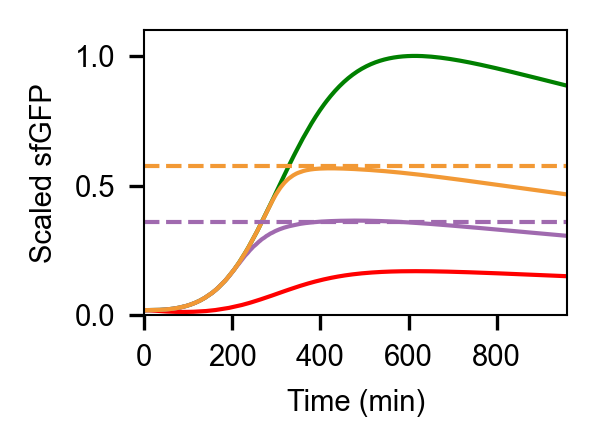

In [9]:
# Typography and layout
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 7,
    'legend.fontsize': 6
})
tick_fontsize = 7

fig, ax = plt.subplots(figsize=(2, 1.5), dpi=300)
lwd = 1

# Model predictions
ax.plot(time_green, green_sim_norm, color='green', linestyle='-', linewidth=lwd, label='Green Constant')
ax.plot(time_red, red_sim_norm, color='red', linestyle='-', linewidth=lwd, label='Red Constant')
ax.plot(t_p1, pctrl_1_norm, color=color_dict['set_point_1'], linewidth=lwd, label='P-Control Setpoint 1')
ax.plot(t_p2, pctrl_2_norm, color=color_dict['set_point_2'], linewidth=lwd, label='P-Control Setpoint 2')

# Setpoint lines
ax.axhline(y=set_pt_1_norm, color=color_dict['set_point_1'], linestyle='--', linewidth=lwd)
ax.axhline(y=set_pt_2_norm, color=color_dict['set_point_2'], linestyle='--', linewidth=lwd)

# Axes
ax.set_xlabel('Time (min)')
ax.set_ylabel('Scaled sfGFP')
ax.set_xlim(0, 960)
ax.set_ylim(0, 1.1)
ax.set_xticks([0, 200, 400, 600, 800])
ax.set_yticks([0, 0.5, 1.0])

# Legend
#ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

# Grid
#ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

# Spine control
spine_width = 0.5
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(spine_width)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Layout and export
fig.subplots_adjust(right=0.75)
plt.tight_layout()
#plt.savefig('figures/g. p_control_3eqn_model_no_deadtime.svg', format='svg', dpi=300, bbox_inches='tight', transparent=True)

In [10]:
# Print the overshoot error % to compare with experiments
overshoot_error_1 = 100 * (np.max(pctrl_1_norm) - set_pt_1_norm) / set_pt_1_norm
overshoot_error_2 = 100 * (np.max(pctrl_2_norm) - set_pt_2_norm)/ set_pt_2_norm

overshoot_error_1, overshoot_error_2

(1.7697392357379937, -1.7704399055806732)